# My Content - Recommender System

## Téléchargement et Prétraitement des Données

Dans ce notebook, nous allons télécharger les fichiers de données et les prétraiter pour le système de recommandation.

In [45]:
%pip install --use-pep517 annoy
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [46]:
# Importation des bibliothèques nécessaires
import os
import requests
import zipfile
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from flask import Flask, request, jsonify, render_template
import joblib

# Importation de TensorFlow
import tensorflow as tf

from annoy import AnnoyIndex

# Importation de MLflow
import mlflow
import mlflow.sklearn

# Importation des bibliothèques de scikit-learn
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA


In [47]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available:  0


## Téléchargement des fichiers de données

Nous allons télécharger les fichiers de données depuis les liens fournis et les enregistrer dans le répertoire `../data`.

In [48]:
# Fonction pour télécharger un fichier
def download_file(url, dest_path):
    if not os.path.exists(dest_path):
        try:
            response = requests.get(url)
            response.raise_for_status()  # Vérifie si la requête a réussi
            with open(dest_path, 'wb') as file:
                file.write(response.content)
            print(f'Téléchargement terminé : {dest_path}')
        except requests.exceptions.RequestException as e:
            print(f'Erreur lors du téléchargement : {e}')
    else:
        print(f'Le fichier {dest_path} existe déjà. Téléchargement non nécessaire.')

# URL du fichier zip contenant les données
data_url = 'https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/AI+Engineer/Project+9+-+R%C3%A9alisez+une+application+mobile+de+recommandation+de+contenu/news-portal-user-interactions-by-globocom.zip'

# Chemin de destination pour le fichier zip
zip_file_path = '../data/news-portal-user-interactions-by-globocom.zip'

# Création du répertoire data s'il n'existe pas
if not os.path.exists('../data'):
    os.makedirs('../data', exist_ok=True)
    print('Répertoire ../data créé.')

# Téléchargement du fichier zip
download_file(data_url, zip_file_path)

# Décompression du fichier zip
try:
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall('../data')
    print('Extraction terminée.')
except zipfile.BadZipFile:
    print('Erreur : Le fichier zip est corrompu.')

# Chemins des fichiers extraits
clicks_zip_path = '../data/clicks.zip'
clicks_sample_path = '../data/clicks_sample.csv'
articles_metadata_path = '../data/articles_metadata.csv'
articles_embeddings_path = '../data/articles_embeddings.pickle'

# Vérification des fichiers extraits
if all(os.path.exists(path) for path in [clicks_zip_path, clicks_sample_path, articles_metadata_path, articles_embeddings_path]):
    print(f'Fichiers extraits:\n- {clicks_zip_path}\n- {clicks_sample_path}\n- {articles_metadata_path}\n- {articles_embeddings_path}')
else:
    print('Erreur lors de l\'extraction des fichiers.')

# Décompression de clicks.zip
if os.path.exists(clicks_zip_path):
    try:
        with zipfile.ZipFile(clicks_zip_path, 'r') as zip_ref:
            zip_ref.extractall('../data')
        print('Extraction de clicks.zip terminée.')
    except zipfile.BadZipFile:
        print('Erreur : Le fichier clicks.zip est corrompu.')

# Chemin des fichiers extraits de clicks.zip
clicks_path = '../data/clicks.zip'

# Décompression de clicks.zip
clicks_extract_dir = '../data/clicks/'
if not os.path.exists(clicks_extract_dir):
    os.makedirs(clicks_extract_dir, exist_ok=True)
    try:
        with zipfile.ZipFile(clicks_zip_path, 'r') as zip_ref:
            zip_ref.extractall(clicks_extract_dir)
        print('Extraction de clicks.zip terminée.')
    except zipfile.BadZipFile:
        print('Erreur : Le fichier clicks.zip est corrompu.')
else:
    print(f'Le répertoire {clicks_extract_dir} existe déjà. Extraction non nécessaire.')



Le fichier ../data/news-portal-user-interactions-by-globocom.zip existe déjà. Téléchargement non nécessaire.
Extraction terminée.
Fichiers extraits:
- ../data/clicks.zip
- ../data/clicks_sample.csv
- ../data/articles_metadata.csv
- ../data/articles_embeddings.pickle
Extraction de clicks.zip terminée.
Le répertoire ../data/clicks/ existe déjà. Extraction non nécessaire.


## Chargement et aperçu des données

Nous allons maintenant charger les fichiers CSV et afficher un aperçu des données.

In [49]:
# Lecture des fichiers CSV extraits de clicks.zip
clicks_files = [os.path.join(clicks_extract_dir, f) for f in os.listdir(clicks_extract_dir) if f.endswith('.csv')]

# Concaténation de tous les fichiers CSV en un seul DataFrame
temp_clicks_df = pd.concat([pd.read_csv(f) for f in clicks_files], ignore_index=True)

# Lecture des autres fichiers
temp_clicks_sample_df = pd.read_csv(clicks_sample_path)
temp_articles_metadata_df = pd.read_csv(articles_metadata_path)

# Lecture du fichier pickle
with open(articles_embeddings_path, 'rb') as file:
    articles_embeddings = pickle.load(file)

# Aperçu des fichiers
print("Aperçu du DataFrame de clicks concaténé:")
print(temp_clicks_df.head(), "\n")

print("Informations sur le DataFrame de clicks concaténé:")
print(temp_clicks_df.info(), "\n")

print("Aperçu du fichier clicks_sample.csv:")
print(temp_clicks_sample_df.head(), "\n")

print("Informations sur le fichier clicks_sample.csv:")
print(temp_clicks_sample_df.info(), "\n")

print("Aperçu du fichier articles_metadata.csv:")
print(temp_articles_metadata_df.head(), "\n")

print("Informations sur le fichier articles_metadata.csv:")
print(temp_articles_metadata_df.info(), "\n")

print("Aperçu des embeddings d'articles:")
print(f"Nombre d'articles : {len(articles_embeddings)}")
print(f"Exemple d'embedding pour le premier article : {articles_embeddings[0]}")

Aperçu du DataFrame de clicks concaténé:
  user_id        session_id  session_start session_size click_article_id  \
0   93863  1507865792177843  1507865792000            2            96210   
1   93863  1507865792177843  1507865792000            2           158094   
2  294036  1507865795185844  1507865795000            2            20691   
3  294036  1507865795185844  1507865795000            2            96210   
4   77136  1507865796257845  1507865796000            2           336245   

  click_timestamp click_environment click_deviceGroup click_os click_country  \
0   1507865832925                 4                 3        2             1   
1   1507865862925                 4                 3        2             1   
2   1507865819095                 4                 3       20             1   
3   1507865849095                 4                 3       20             1   
4   1507866133178                 4                 3        2             1   

  click_region click_

clicks_sample.csv :
Contient des données similaires aux fichiers extraits de clicks.zip.
Aperçu des 5 premières lignes et informations sur les colonnes et types de données.
articles_metadata.csv :
Contient des métadonnées sur les articles, comme le nombre de mots et autres caractéristiques.
Aperçu des 5 premières lignes et informations sur les colonnes et types de données.
articles_embeddings.pickle :
Contient les embeddings des articles (représentations vectorielles).
Nombre total d'articles : 364047
Exemple d'embedding pour le premier article : [0.08109499, 0.0563579, 0.21711417, ...]

In [50]:
# Charger les fichiers CSV
clicks_sample_df = pd.read_csv(clicks_sample_path, usecols=['user_id', 'click_article_id', 'click_timestamp'])
articles_metadata_df = pd.read_csv(articles_metadata_path, usecols=['article_id', 'category_id', 'words_count'])

# Concaténer les fichiers de clics
clicks_files = [os.path.join(clicks_extract_dir, f) for f in os.listdir(clicks_extract_dir) if f.endswith('.csv')]

# Lire et concaténer tous les fichiers de clics
df_list = []
for file in clicks_files:
    df = pd.read_csv(file, usecols=['user_id', 'click_article_id', 'click_timestamp'])
    df_list.append(df)

clicks_concat_df = pd.concat(df_list, ignore_index=True)

# Afficher un aperçu des DataFrames
print("Aperçu du DataFrame de clicks concaténé:")
print(clicks_concat_df.head(), "\n")
print("Informations sur le DataFrame de clicks concaténé:")
print(clicks_concat_df.info(), "\n")

print("Aperçu du fichier clicks_sample.csv:")
print(clicks_sample_df.head(), "\n")
print("Informations sur le fichier clicks_sample.csv:")
print(clicks_sample_df.info(), "\n")

print("Aperçu du fichier articles_metadata.csv:")
print(articles_metadata_df.head(), "\n")
print("Informations sur le fichier articles_metadata.csv:")
print(articles_metadata_df.info(), "\n")

Aperçu du DataFrame de clicks concaténé:
  user_id click_article_id click_timestamp
0   93863            96210   1507865832925
1   93863           158094   1507865862925
2  294036            20691   1507865819095
3  294036            96210   1507865849095
4   77136           336245   1507866133178 

Informations sur le DataFrame de clicks concaténé:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2988181 entries, 0 to 2988180
Data columns (total 3 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   user_id           object
 1   click_article_id  object
 2   click_timestamp   object
dtypes: object(3)
memory usage: 68.4+ MB
None 

Aperçu du fichier clicks_sample.csv:
   user_id  click_article_id  click_timestamp
0        0            157541    1506826828020
1        0             68866    1506826858020
2        1            235840    1506827017951
3        1             96663    1506827047951
4        2            119592    1506827090575 

Informations sur le fic

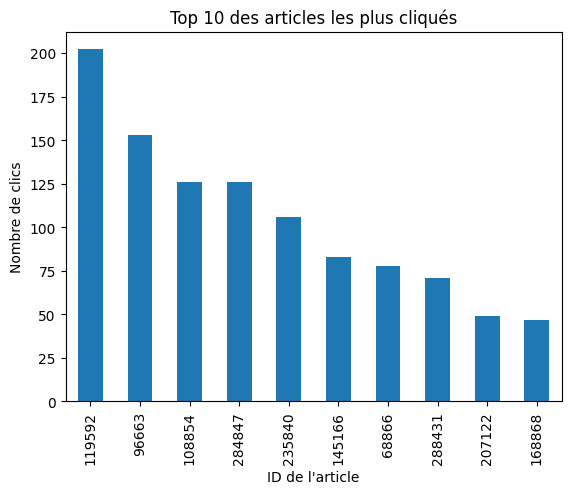

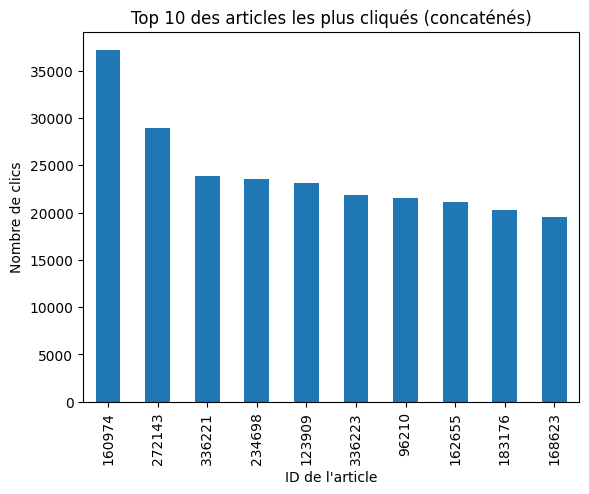

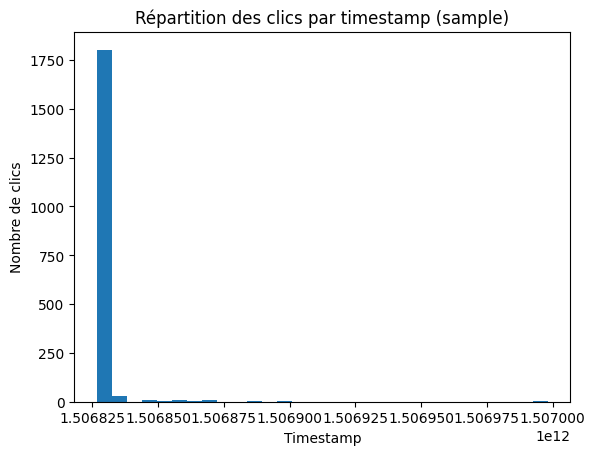

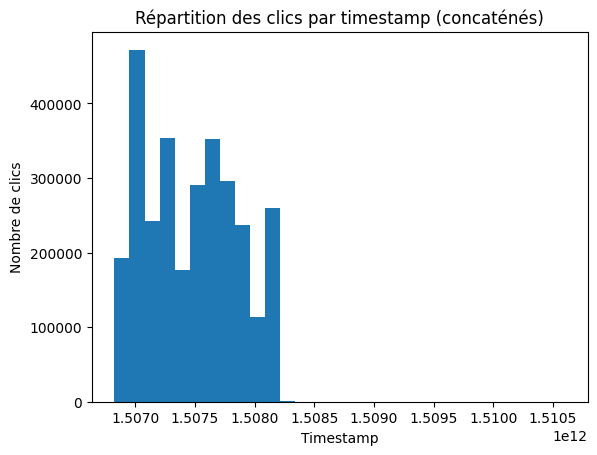

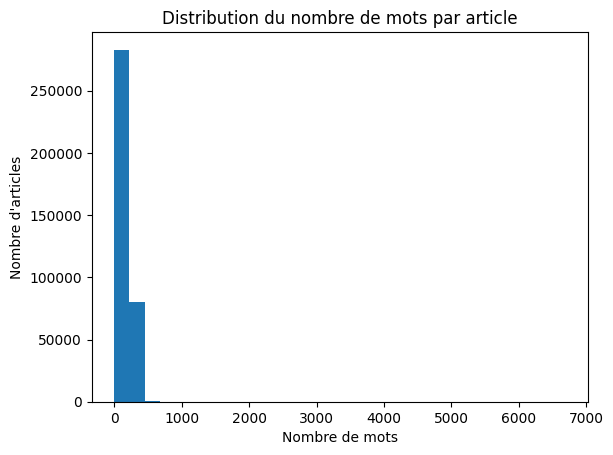

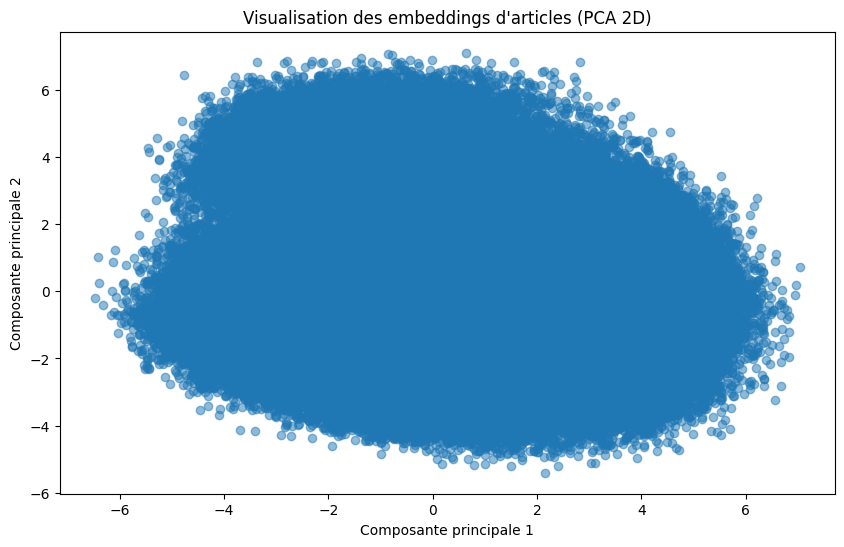

In [51]:
# Distribution des clics par article dans clicks_sample.csv
clicks_sample_df['click_article_id'].value_counts().head(10).plot(kind='bar')
plt.title('Top 10 des articles les plus cliqués')
plt.xlabel('ID de l\'article')
plt.ylabel('Nombre de clics')
plt.show()

# Distribution des clics par article dans le DataFrame concaténé
clicks_concat_df['click_article_id'].value_counts().head(10).plot(kind='bar')
plt.title('Top 10 des articles les plus cliqués (concaténés)')
plt.xlabel('ID de l\'article')
plt.ylabel('Nombre de clics')
plt.show()

# Répartition des clics par timestamp dans clicks_sample.csv
clicks_sample_df['click_timestamp'].plot(kind='hist', bins=30)
plt.title('Répartition des clics par timestamp (sample)')
plt.xlabel('Timestamp')
plt.ylabel('Nombre de clics')
plt.show()

# Répartition des clics par timestamp dans le DataFrame concaténé
clicks_concat_df['click_timestamp'].plot(kind='hist', bins=30)
plt.title('Répartition des clics par timestamp (concaténés)')
plt.xlabel('Timestamp')
plt.ylabel('Nombre de clics')
plt.show()

# Distribution du nombre de mots par article dans articles_metadata.csv
articles_metadata_df['words_count'].plot(kind='hist', bins=30)
plt.title('Distribution du nombre de mots par article')
plt.xlabel('Nombre de mots')
plt.ylabel('Nombre d\'articles')
plt.show()


# Distribution des embeddings (représentation 2D avec PCA)
pca = PCA(n_components=2)
articles_embeddings_2d = pca.fit_transform(articles_embeddings)

plt.figure(figsize=(10, 6))
plt.scatter(articles_embeddings_2d[:, 0], articles_embeddings_2d[:, 1], alpha=0.5)
plt.title('Visualisation des embeddings d\'articles (PCA 2D)')
plt.xlabel('Composante principale 1')
plt.ylabel('Composante principale 2')
plt.show()


## Préparation des données
Nous allons maintenant prétraiter les données pour le modèle de recommandation.

In [52]:
# Analyse des données
analysis_results = {}

# Valeurs manquantes
analysis_results['clicks_sample_missing'] = clicks_sample_df.isnull().sum()
analysis_results['articles_metadata_missing'] = articles_metadata_df.isnull().sum()
analysis_results['clicks_concat_missing'] = clicks_concat_df.isnull().sum()

# Doublons
analysis_results['clicks_sample_duplicates'] = clicks_sample_df.duplicated().sum()
analysis_results['articles_metadata_duplicates'] = articles_metadata_df.duplicated().sum()
analysis_results['clicks_concat_duplicates'] = clicks_concat_df.duplicated().sum()

# Afficher les résultats de l'analyse
analysis_results


{'clicks_sample_missing': user_id             0
 click_article_id    0
 click_timestamp     0
 dtype: int64,
 'articles_metadata_missing': article_id     0
 category_id    0
 words_count    0
 dtype: int64,
 'clicks_concat_missing': user_id             0
 click_article_id    0
 click_timestamp     0
 dtype: int64,
 'clicks_sample_duplicates': 0,
 'articles_metadata_duplicates': 0,
 'clicks_concat_duplicates': 0}

# Préparation des Données

## Encodage des variables catégorielles

In [59]:
def encode_variables(clicks_df, articles_metadata_df):
    label_encoder_user = LabelEncoder()
    label_encoder_article = LabelEncoder()

    # Ajuster le LabelEncoder sur tous les articles présents dans les deux DataFrames
    all_articles = pd.concat([clicks_df['click_article_id'], articles_metadata_df['article_id']]).unique()
    label_encoder_article.fit(all_articles)

    clicks_df['user_id'] = label_encoder_user.fit_transform(clicks_df['user_id'])
    clicks_df['click_article_id'] = label_encoder_article.transform(clicks_df['click_article_id'])
    articles_metadata_df['article_id'] = label_encoder_article.transform(articles_metadata_df['article_id'])

    return clicks_df, articles_metadata_df, label_encoder_user, label_encoder_article

clicks_df, articles_metadata_df, label_encoder_user, label_encoder_article = encode_variables(clicks_df, articles_metadata_df)

# Utilisation des embeddings d'articles pour les features basées sur le texte

In [60]:
def add_embeddings(articles_metadata_df, articles_embeddings):
    articles_metadata_df['embedding'] = articles_metadata_df['article_id'].apply(lambda x: articles_embeddings[x])
    return articles_metadata_df

articles_metadata_df = add_embeddings(articles_metadata_df, articles_embeddings)

# Construction des matrices utilisateur-article et application de SVD

In [61]:
def build_user_article_matrix(clicks_df):
    clicks_df['interaction'] = 1  # Ajouter une colonne d'interaction binaire
    user_article_matrix = clicks_df.pivot(index='user_id', columns='click_article_id', values='interaction')
    user_article_matrix.fillna(0, inplace=True)
    return user_article_matrix

user_article_matrix = build_user_article_matrix(clicks_df)

def apply_svd(user_article_matrix, n_components=100):
    svd = TruncatedSVD(n_components=n_components)
    reduced_user_article_matrix = svd.fit_transform(user_article_matrix)
    return reduced_user_article_matrix, svd

reduced_user_article_matrix, svd = apply_svd(user_article_matrix)

# Sauvegarde des matrices et des objets transformés pour une utilisation ultérieure

In [62]:
def save_models(user_article_matrix, articles_metadata_df, label_encoder_user, label_encoder_article, svd):
    joblib.dump(user_article_matrix, 'models/user_article_matrix.pkl')
    joblib.dump(articles_metadata_df, 'models/articles_metadata_with_embeddings.pkl')
    joblib.dump(label_encoder_user, 'models/label_encoder_user.pkl')
    joblib.dump(label_encoder_article, 'models/label_encoder_article.pkl')
    joblib.dump(svd, 'models/svd_model.pkl')

save_models(user_article_matrix, articles_metadata_df, label_encoder_user, label_encoder_article, svd)

# Recommandation basée sur la similarité article-article

In [63]:
def calculate_article_similarity(reduced_user_article_matrix):
    article_similarity = cosine_similarity(reduced_user_article_matrix.T)
    return article_similarity

article_similarity = calculate_article_similarity(reduced_user_article_matrix)

def recommend_articles_article_based(article_id, article_similarity, user_article_matrix, num_recommendations=5):
    if article_id in user_article_matrix.columns:
        article_idx = user_article_matrix.columns.get_loc(article_id)
        similar_articles = list(enumerate(article_similarity[article_idx]))
        similar_articles = sorted(similar_articles, key=lambda x: x[1], reverse=True)
        recommended_articles = [user_article_matrix.columns[i[0]] for i in similar_articles[1:num_recommendations+1]]
        return recommended_articles
    else:
        return []

# Exemple de recommandation d'articles pour un article donné
article_id_example = user_article_matrix.columns[0]
print(f"Recommandations pour l'article {article_id_example} : {recommend_articles_article_based(article_id_example, article_similarity, user_article_matrix)}")

Recommandations pour l'article 2137 : [123750, 119291, 106933, 114349, 119592]


# Recommandation basée sur les métadonnées des articles (TF-IDF et similarité cosinus)

In [64]:
def recommend_articles_metadata_based(article_id, articles_metadata_df, cosine_sim, num_recommendations=5):
    if article_id in articles_metadata_df['article_id'].values:
        article_idx = articles_metadata_df.index[articles_metadata_df['article_id'] == article_id][0]
        similar_articles = list(enumerate(cosine_sim[article_idx]))
        similar_articles = sorted(similar_articles, key=lambda x: x[1], reverse=True)
        recommended_articles = [articles_metadata_df['article_id'].iloc[i[0]] for i in similar_articles[1:num_recommendations+1]]
        return recommended_articles
    else:
        return []

# Exemple de recommandation d'articles basée sur les métadonnées pour un article donné
article_id_example = articles_metadata_df['article_id'].iloc[0]
print(f"Recommandations basées sur les métadonnées pour l'article {article_id_example} : {recommend_articles_metadata_based(article_id_example, articles_metadata_df, cosine_sim)}")

Recommandations basées sur les métadonnées pour l'article 0 : [1, 2, 3, 4, 5]


# Recommandation Hybride

In [65]:
def hybrid_recommendation(user_id, user_article_matrix, article_similarity, articles_metadata_df, cosine_sim, num_recommendations=5):
    user_articles = user_article_matrix.loc[user_id]
    interacted_articles = user_articles[user_articles > 0].index.tolist()

    collaborative_recommendations = []
    content_based_recommendations = []

    for article_id in interacted_articles:
        collaborative_recommendations.extend(recommend_articles_article_based(article_id, article_similarity, user_article_matrix, num_recommendations))
        content_based_recommendations.extend(recommend_articles_metadata_based(article_id, articles_metadata_df, cosine_sim, num_recommendations))

    # Combiné et enlever les doublons
    combined_recommendations = list(set(collaborative_recommendations + content_based_recommendations))
    return combined_recommendations[:num_recommendations]

# Exemple d'utilisation
user_id_example = user_article_matrix.index[0]

collaborative_recommendations = recommend_articles_article_based(user_article_matrix.columns[0], article_similarity, user_article_matrix, num_recommendations=5)
content_recommendations = recommend_articles_metadata_based(articles_metadata_df['article_id'].iloc[0], articles_metadata_df, cosine_sim, num_recommendations=5)
hybrid_recommendations = hybrid_recommendation(user_id_example, user_article_matrix, article_similarity, articles_metadata_df, cosine_sim, num_recommendations=5)

# Créer un DataFrame pour les recommandations avec des NaN pour combler les listes plus courtes
max_length = max(len(collaborative_recommendations), len(content_recommendations), len(hybrid_recommendations))
recommendations_df = pd.DataFrame({
    'Collaboratif': pd.Series(collaborative_recommendations),
    'Contenu': pd.Series(content_recommendations),
    'Hybride': pd.Series(hybrid_recommendations)
})

# Tracer les recommandations
recommendations_df.plot(kind='bar', figsize=(14, 7))
plt.xlabel('Type de Recommandation')
plt.ylabel('Article ID')
plt.title(f'Recommandations pour l\'utilisateur {user_id_example}')
plt.legend(title='Type de Recommandation')
plt.show()

IndexError: index 128 is out of bounds for axis 0 with size 100

In [53]:
import pandas as pd
import joblib
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Définir les chemins des fichiers pour sample et prod
sample_mode = True

if sample_mode:
    clicks_df = clicks_sample_df
else:
    clicks_df = clicks_concat_df

def prepare_data(clicks_df, articles_metadata_df, articles_embeddings):
    # Encodage des variables catégorielles
    label_encoder_user = LabelEncoder()
    label_encoder_article = LabelEncoder()

    # Ajuster le LabelEncoder sur tous les articles présents dans les deux DataFrames
    all_articles = pd.concat([clicks_sample_df['click_article_id'], articles_metadata_df['article_id']]).unique()
    label_encoder_article.fit(all_articles)

    clicks_df['user_id'] = label_encoder_user.fit_transform(clicks_df['user_id'])
    clicks_df['click_article_id'] = label_encoder_article.transform(clicks_df['click_article_id'])
    articles_metadata_df['article_id'] = label_encoder_article.transform(articles_metadata_df['article_id'])

    # Utilisation des embeddings d'articles pour les features basées sur le texte
    articles_metadata_df['embedding'] = articles_metadata_df['article_id'].apply(lambda x: articles_embeddings[x])

    # Construction des matrices utilisateur-article
    clicks_df['interaction'] = 1  # Ajouter une colonne d'interaction binaire
    user_article_matrix = clicks_df.pivot(index='user_id', columns='click_article_id', values='interaction')
    user_article_matrix.fillna(0, inplace=True)

    return user_article_matrix, articles_metadata_df, label_encoder_user, label_encoder_article

# Préparation des données
user_article_matrix, articles_metadata_df, label_encoder_user, label_encoder_article = prepare_data(clicks_df, articles_metadata_df, articles_embeddings)

# Sauvegarde des matrices pour une utilisation ultérieure
user_article_matrix.to_csv('user_article_matrix.csv')

# Aperçu des transformations
print("Aperçu de clicks_sample_df:")
print(clicks_df.head(), "\n")
print("Aperçu de articles_metadata_df:")
print(articles_metadata_df.head(), "\n")
print("Aperçu de la matrice utilisateur-article:")
print(user_article_matrix.head(), "\n")

# Sauvegarder les matrices et les objets transformés pour une utilisation ultérieure
joblib.dump(user_article_matrix, 'models/user_article_matrix.pkl')
joblib.dump(articles_metadata_df, 'models/articles_metadata_with_embeddings.pkl')
joblib.dump(label_encoder_user, 'models/label_encoder_user.pkl')
joblib.dump(label_encoder_article, 'models/label_encoder_article.pkl')


Aperçu de clicks_sample_df:
   user_id  click_article_id  click_timestamp  interaction
0        0            157541    1506826828020            1
1        0             68866    1506826858020            1
2        1            235840    1506827017951            1
3        1             96663    1506827047951            1
4        2            119592    1506827090575            1 

Aperçu de articles_metadata_df:
   article_id  category_id  words_count  \
0           0            0          168   
1           1            1          189   
2           2            1          250   
3           3            1          230   
4           4            1          162   

                                           embedding  
0  [-0.16118301, -0.95723313, -0.13794445, 0.0508...  
1  [-0.52321565, -0.974058, 0.73860806, 0.1552344...  
2  [-0.61961854, -0.9729604, -0.20736018, -0.1288...  
3  [-0.7408434, -0.97574896, 0.39169782, 0.641737...  
4  [-0.2790515, -0.97231525, 0.68537366, 0.113056.

['models/label_encoder_article.pkl']

## Collaborative Filtering (CF) :

### Recommandation Basée sur le Filtrage Collaboratif

Le code utilise la similarité cosinus pour calculer la similarité entre les articles en fonction des interactions utilisateur-article. 
La fonction recommend_articles_article_based fournit des recommandations basées sur cette similarité.

In [54]:
# Calcul de la similarité article-article
article_similarity = cosine_similarity(user_article_matrix.T)

# Fonction de recommandation basée sur la similarité article-article
def recommend_articles_article_based(article_id, num_recommendations=5):
    if article_id in user_article_matrix.columns:
        article_idx = user_article_matrix.columns.get_loc(article_id)
        similar_articles = list(enumerate(article_similarity[article_idx]))
        similar_articles = sorted(similar_articles, key=lambda x: x[1], reverse=True)
        recommended_articles = [user_article_matrix.columns[i[0]] for i in similar_articles[1:num_recommendations+1]]
        return recommended_articles
    else:
        return []


# Exemple de recommandation d'articles pour un article donné
article_id_example = user_article_matrix.columns[0]
print(f"Recommandations pour l'article {article_id_example} : {recommend_articles_article_based(article_id_example)}")

Recommandations pour l'article 2137 : [272947, 159359, 2662, 4243, 4658]


# Content-based :

### Recommandation Basée sur le Contenu

Le code utilise la similarité cosinus entre les articles en fonction de leurs représentations textuelles (TF-IDF). 
La fonction recommend_articles_content_based fournit des recommandations basées sur cette similarité.


In [55]:
articles_metadata_df['article_content'] = articles_metadata_df['article_id'].astype(str)

# Calcul de la matrice TF-IDF
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(articles_metadata_df['article_content'])

# Calcul de la similarité cosinus
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Fonction de recommandation basée sur la similarité des métadonnées des articles (TF-IDF et cosinus)
def recommend_articles_content_based(article_id, num_recommendations=5):
    if article_id in articles_metadata_df['article_id'].values:
        article_idx = articles_metadata_df.index[articles_metadata_df['article_id'] == article_id][0]
        similar_articles = list(enumerate(cosine_sim[article_idx]))
        similar_articles = sorted(similar_articles, key=lambda x: x[1], reverse=True)
        recommended_articles = [articles_metadata_df['article_id'].iloc[i[0]] for i in similar_articles[1:num_recommendations+1]]
        return recommended_articles
    else:
        return []


# Exemple de recommandation d'articles basée sur le contenu pour un article donné
article_id_example = articles_metadata_df['article_id'].iloc[0]
print(f"Recommandations basées sur le contenu pour l'article {article_id_example} : {recommend_articles_content_based(article_id_example)}")

Recommandations basées sur le contenu pour l'article 0 : [1, 2, 3, 4, 5]


## Recommandation Hybride
- Chargement de la matrice utilisateur-article : On charge la matrice utilisateur-article préalablement sauvegardée.
- Calcul de la similarité article-article : Utilisation de cosine_similarity pour calculer la similarité entre les articles.
- Fonction de recommandation : La fonction prend en entrée un article_id et retourne les articles les plus similaires basés sur la similarité calculée.
- Affichage des recommandations pour un exemple d'article.

In [56]:
# Fonction de recommandation collaborative
def recommend_articles_collaborative(user_id, num_recommendations=5):
    if user_id in user_article_matrix.index:
        user_clicks = user_article_matrix.loc[user_id]
        user_clicks = user_clicks[user_clicks > 0]
        collaborative_recommendations = []
        for article_id in user_clicks.index:
            similar_articles = recommend_articles_article_based(article_id, num_recommendations)
            collaborative_recommendations.extend(similar_articles)
        collaborative_recommendations = list(set(collaborative_recommendations))
        return collaborative_recommendations[:num_recommendations]
    else:
        return []

# Fonction de recommandation hybride
def hybrid_recommendation(user_id, num_recommendations=5):
    collaborative_recommendations = recommend_articles_collaborative(user_id, num_recommendations)
    content_based_recommendations = []

    user_interactions = user_article_matrix.loc[user_id]
    article_indices = user_interactions[user_interactions > 0].index.tolist()

    for article_id in article_indices:
        content_based_recommendations.extend(recommend_articles_content_based(article_id, num_recommendations))

    combined_recommendations = list(set(collaborative_recommendations + content_based_recommendations))
    return combined_recommendations[:num_recommendations]

# Exemple de recommandation hybride pour un utilisateur donné
user_id_example = user_article_matrix.index[0]
print(f"Recommandations hybrides pour l'utilisateur {user_id_example} : {hybrid_recommendation(user_id_example)}")


Recommandations hybrides pour l'utilisateur 0 : [0, 1, 2, 3, 4]


## Sauvegarde des données prétraitées

Nous allons sauvegarder les données prétraitées pour une utilisation ultérieure dans l'entraînement du modèle.

In [57]:
import joblib
# Importation des bibliothèques nécessaires
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from flask import Flask, request, jsonify
import joblib
import numpy as np
import pandas as pd

# Chemins relatifs pour sauvegarder les modèles et les données
article_user_matrix_path = 'models/article_user_matrix.pkl'
article_similarity_path = 'models/article_similarity.pkl'
tfidf_vectorizer_path = 'models/tfidf_vectorizer.pkl'
tfidf_matrix_path = 'models/tfidf_matrix.pkl'

# Créer le répertoire 'models' s'il n'existe pas
import os
if not os.path.exists('models'):
    os.makedirs('models')

# Enregistrer et suivre les modèles
joblib.dump(article_user_matrix, article_user_matrix_path)
joblib.dump(article_similarity, article_similarity_path)
joblib.dump(tfidf_vectorizer, tfidf_vectorizer_path)
joblib.dump(tfidf_matrix, tfidf_matrix_path)

print("Modèles et données préparées sauvegardés.")

Modèles et données préparées sauvegardés.


### Diagramme en Barres des Recommandations pour un Utilisateur Spécifique
Ce diagramme en barres montre les articles recommandés pour un utilisateur spécifique en fonction de trois méthodes : le filtrage collaboratif, le filtrage basé sur le contenu et l'approche hybride. Cela permet de comparer les différents types de recommandations et d'observer les similitudes ou différences entre elles. En visualisant les recommandations, nous pouvons mieux comprendre l'impact de chaque méthode et comment elles se complètent dans l'approche hybride.

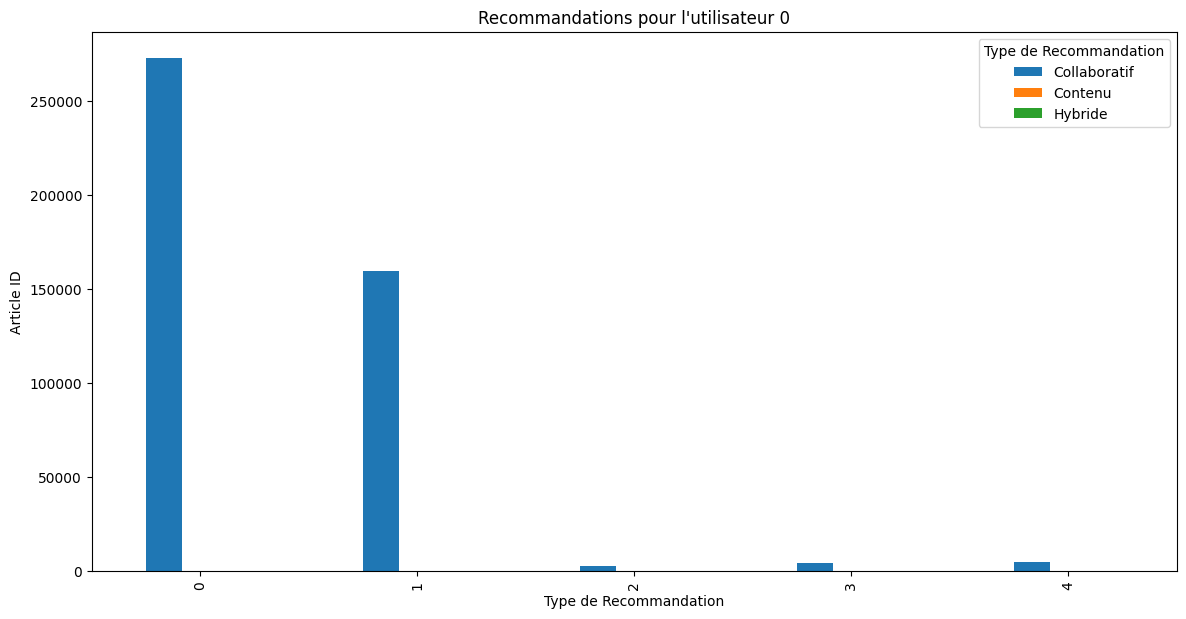

In [58]:
user_id_example = user_article_matrix.index[0]

collaborative_recommendations = recommend_articles_article_based(article_user_matrix.columns[0], num_recommendations=5)
content_recommendations = recommend_articles_content_based(articles_metadata_df['article_id'].iloc[0], num_recommendations=5)
hybrid_recommendations = hybrid_recommendation(user_id_example, num_recommendations=5)

# Créer un DataFrame pour les recommandations
recommendations_df = pd.DataFrame({
    'Collaboratif': collaborative_recommendations,
    'Contenu': content_recommendations,
    'Hybride': hybrid_recommendations
})

# Remplir les valeurs manquantes avec NaN
recommendations_df = recommendations_df.apply(lambda x: pd.Series(x).dropna().reset_index(drop=True))

# Tracer les recommandations
recommendations_df.plot(kind='bar', figsize=(14, 7))
plt.xlabel('Type de Recommandation')
plt.ylabel('Article ID')
plt.title(f'Recommandations pour l\'utilisateur {user_id_example}')
plt.legend(title='Type de Recommandation')
plt.show()

### Visualisation des Matrices de Similarité
Cette heatmap montre les similarités cosinus entre les 10 premiers articles de la matrice de similarité. Chaque cellule représente la similarité entre deux articles, avec des couleurs plus claires indiquant des similarités plus élevées. En visualisant une partie de la matrice de similarité, nous pouvons obtenir une idée de la structure des similarités dans nos données, identifier des groupes d'articles similaires et évaluer visuellement l'efficacité de notre modèle de similarité.

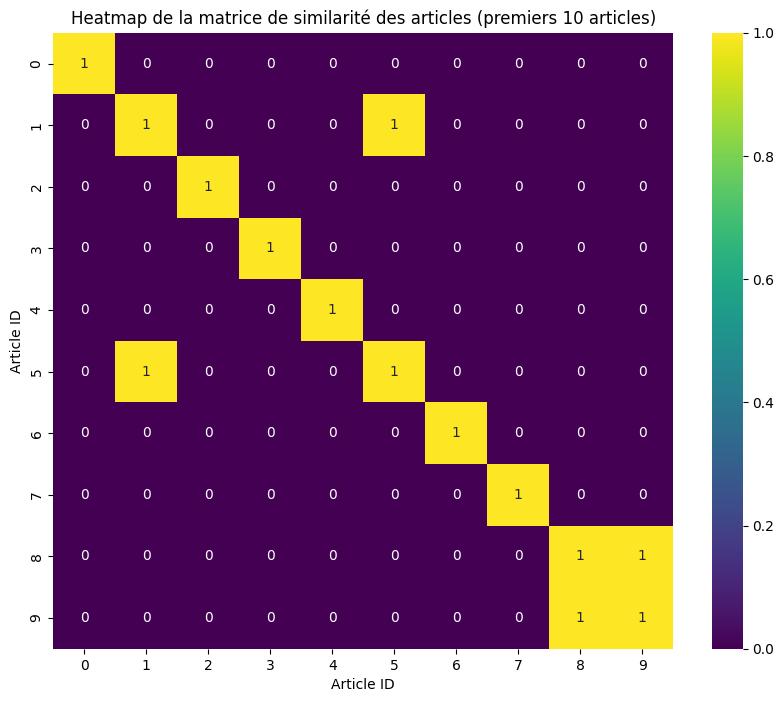

In [28]:
# Visualisation de la matrice de similarité pour les articles
plt.figure(figsize=(10, 8))
sns.heatmap(article_similarity[:10, :10], cmap='viridis', annot=True)
plt.title('Heatmap de la matrice de similarité des articles (premiers 10 articles)')
plt.xlabel('Article ID')
plt.ylabel('Article ID')
plt.show()

## Déploiement Serverless avec Azure Functions
Api local de test

In [2]:
from flask import Flask, request, jsonify
import joblib
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

app = Flask(__name__)

# Chemins relatifs des fichiers sauvegardés
article_user_matrix_path = 'models/article_user_matrix.pkl'
article_similarity_path = 'models/article_similarity.pkl'
tfidf_vectorizer_path = 'models/tfidf_vectorizer.pkl'
tfidf_matrix_path = 'models/tfidf_matrix.pkl'
articles_metadata_path = '../data/articles_metadata.csv'

# Charger les fichiers sauvegardés
article_user_matrix = joblib.load(article_user_matrix_path)
article_similarity = joblib.load(article_similarity_path)
tfidf_vectorizer = joblib.load(tfidf_vectorizer_path)
tfidf_matrix = joblib.load(tfidf_matrix_path)

# Charger les métadonnées des articles
articles_metadata_df = pd.read_csv(articles_metadata_path)

# Fonction de recommandation collaborative
def collaborative_recommendation(user_id, num_recommendations=5):
    if user_id in article_user_matrix.index:
        user_clicks = article_user_matrix.loc[user_id]
        user_clicks = user_clicks[user_clicks > 0]
        collaborative_recommendations = []
        for article_id in user_clicks.index:
            similar_articles = np.argsort(article_similarity[article_id])[::-1]
            collaborative_recommendations.extend(similar_articles[:num_recommendations])
        collaborative_recommendations = list(set(collaborative_recommendations))
        return collaborative_recommendations[:num_recommendations]
    else:
        return []

# Fonction de recommandation basée sur le contenu
def content_based_recommendation(article_id, num_recommendations=5):
    if article_id in articles_metadata_df['article_id'].values:
        article_idx = articles_metadata_df[articles_metadata_df['article_id'] == article_id].index[0]
        article_vector = tfidf_matrix[article_idx]
        similarities = cosine_similarity(article_vector, tfidf_matrix).flatten()
        similar_articles = np.argsort(-similarities)[1:num_recommendations+1]
        recommended_articles = articles_metadata_df['article_id'].iloc[similar_articles].tolist()
        return recommended_articles
    else:
        return []

# Fonction de recommandation hybride
def hybrid_recommendation(user_id, num_recommendations=5):
    collaborative_recommendations = collaborative_recommendation(user_id, num_recommendations)
    user_clicks = article_user_matrix.loc[user_id]
    user_clicks = user_clicks[user_clicks > 0]
    content_based_recommendations = []
    for article_id in user_clicks.index:
        content_based_recommendations.extend(content_based_recommendation(article_id, num_recommendations))
    content_based_recommendations = list(set(content_based_recommendations))
    combined_recommendations = list(set(collaborative_recommendations + content_based_recommendations))
    return combined_recommendations[:num_recommendations]

@app.route('/recommend/collaborative', methods=['GET'])
def recommend_collaborative():
    user_id = int(request.args.get('user_id'))
    recommendations = collaborative_recommendation(user_id)
    return jsonify(recommendations)

@app.route('/recommend/content', methods=['GET'])
def recommend_content():
    article_id = int(request.args.get('article_id'))
    recommendations = content_based_recommendation(article_id)
    return jsonify(recommendations)

@app.route('/recommend/hybrid', methods=['GET'])
def recommend_hybrid():
    user_id = int(request.args.get('user_id'))
    recommendations = hybrid_recommendation(user_id)
    return jsonify(recommendations)

if __name__ == '__main__':
    app.run(debug=True, port=5005)  # Utilisation du port 5051 pour éviter les conflits


 * Serving Flask app '__main__'
 * Debug mode: on


 * Running on http://127.0.0.1:5005
Press CTRL+C to quit
 * Restarting with watchdog (fsevents)
Traceback (most recent call last):
  File "/Users/cyrilleguillaud/miniforge3/envs/tf_env/lib/python3.9/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/Users/cyrilleguillaud/miniforge3/envs/tf_env/lib/python3.9/site-packages/traitlets/config/application.py", line 1074, in launch_instance
    app.initialize(argv)
  File "/Users/cyrilleguillaud/miniforge3/envs/tf_env/lib/python3.9/site-packages/traitlets/config/application.py", line 118, in inner
    return method(app, *args, **kwargs)
  File "/Users/cyrilleguillaud/miniforge3/envs/tf_env/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 692, in initialize
    self.init_sockets()
  File "/Users/cyrilleguillaud/miniforge3/envs/tf_env/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 331, in init_sockets
    self.shell_port = self._bind_socket(self.shell_socket, self.shell_port)
  

SystemExit: 1

/Users/cyrilleguillaud/miniforge3/envs/tf_env/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3558: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [3]:
%tb

SystemExit: 1

## Web app


In [ ]:
# web_app.py
from flask import Flask, render_template, request
import requests

app = Flask(__name__, template_folder='templates')

# URL de l'API
API_URL = "http://127.0.0.1:5000"

@app.route('/')
def home():
    return render_template('index.html')

@app.route('/recommend', methods=['POST'])
def recommend():
    user_id = request.form.get('user_id')
    article_id = request.form.get('article_id')
    rec_type = request.form.get('rec_type')

    if rec_type == 'collaborative':
        response = requests.get(f"{API_URL}/recommend/collaborative", params={'user_id': user_id})
    elif rec_type == 'content':
        response = requests.get(f"{API_URL}/recommend/content", params={'article_id': article_id})
    else:  # rec_type == 'hybrid'
        response = requests.get(f"{API_URL}/recommend/hybrid", params={'user_id': user_id})

    recommendations = response.json()

    return render_template('index.html', recommendations=recommendations)

if __name__ == '__main__':
    app.run(debug=True, port=5001)